# Project 4 [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/discussion) Baseline Model

## W207 Applied Machine Learning
## Group members: Julia Ying, Haerang Lee, Sang-hyeb Lee
## Date: March/14/2020



# 0. Setup

tf version: 2.2.0-rc3
pandas version: 1.0.3
keras version: 2.3.0-tf


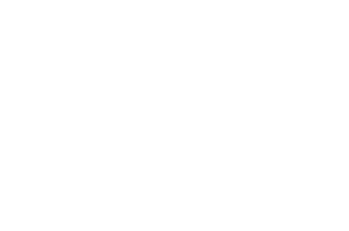

In [10]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform
from skimage.transform import AffineTransform
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.ndimage import rotate, shift

print(f"tf version: {tf.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"keras version: {keras.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 15]
IMAGE_WIDTH = 96
np.random.seed(0)

In [11]:
# mount google drive at /content/drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pickle 

# load data
X_dev = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_img.pkl", "rb" ) )
Y_dev_ffill = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_kp_ffill.pkl", "rb" ) )
Y_dev_median = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_kp_median.pkl", "rb" ) )
Y_dev_knn = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/dev_kp_knn.pkl", "rb" ) )
X_test = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/test_img.pkl", "rb" ) )
X_train = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_img.pkl", "rb" ) )
Y_train_ffill = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_kp_ffill.pkl", "rb" ) )
Y_dev_median = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_kp_median.pkl", "rb" ) )
Y_train_knn = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_kp_knn.pkl", "rb" ) )


# Data augmentation 

(See another notebook for details)

In [0]:
class FacialPointImageDataGenerator(tf.keras.utils.Sequence):
    """FacialPointImageDataGenerator"""

    def __init__(
        self,
        X_data,
        y_data,
        horizontal_flip_prob=0,
        horizontall_flip_label=None,
        shift_range=0.2,
        shift_prob=0,
        rotation_deg_range=20,
        rotation_deg_prob=0,
        to_fit=True,
        batch_size=32,
        image_size=(96, 96),
        n_channels=1,
        shuffle=True,
        preprocess_fn=None,
        convertToRGB=False,
    ):
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.horizontal_flip_prob = horizontal_flip_prob
        self.horizontal_center = image_size[0] // 2
        self.horizontal_flip_batch_size = int(horizontal_flip_prob * batch_size)
        # need to update the labels if we flip the image horizontally
        # for example left_eye_center_x becomes right_eye_center_x
        self.horizontal_flip_label = (
            {
                "orig": [0, 1, 4, 5, 6, 7, 12, 13, 14, 15, 22, 23],
                "new": [2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25],
            }
            if horizontall_flip_label is None
            else horizontall_flip_label
        )

        self.horizontal_flip_fn = np.vectorize(self.horizontal_flip)
        self.shift_range = shift_range
        self.w_shift_max = int(image_size[0] * shift_range)
        self.h_shift_max = int(image_size[1] * shift_range)
        self.shift_prob = shift_prob
        self.rotation_deg_range = rotation_deg_range
        self.rotation_deg_prob = rotation_deg_prob

        self.y_data = y_data
        self.preprocess_fn = preprocess_fn
        self.convertToRGB = convertToRGB

        self.X_data = X_data
        self.on_epoch_end()

    # helpfer function for performing horizontal flip
    @staticmethod
    def horizontal_flip(element, center):
        if element < center:
            element = center + (center - element)
        else:
            element = center - (element - center)
        return element

    def apply_rotation(self, image_array, kp_array, angle):
        # works with one example at a time
        # image_array is an (1, 96, 96, 1) or (1, 96, 96) or (96, 96) array
        # kp_array is an (1, 30) array
        # angle is an integer

        image = image_array.reshape(96, 96)
        rotated_image = rotate(image, angle, reshape=False)

        # 1 by 2 ndarray, [47.5 47.5]
        org_center = (np.array(image.shape[:2][::-1]) - 1) / 2.0

        # 1 by 2 ndarray of where the original center is on the rotated image
        rot_center = (np.array(rotated_image.shape[:2][::-1]) - 1) / 2.0

        kp_zipped = list(zip(kp_array[::2], kp_array[1::2]))

        # how much the original kp offset from the original center
        offsets = [(np.asarray(xy) - org_center) for xy in kp_zipped]

        # rotation angle as radian
        a = np.deg2rad(angle)

        # calculate the rotated key points's offset from the new rotated center
        new_offsets = [
            np.array(
                [
                    xy[0] * np.cos(a) + xy[1] * np.sin(a),
                    -xy[0] * np.sin(a) + xy[1] * np.cos(a),
                ]
            )
            for xy in offsets
        ]

        # calculate the rotated key points
        new_kp_tuples = [xy + rot_center for xy in new_offsets]

        new_kp = []
        for tup in new_kp_tuples:
            new_kp.append(tup[0])
            new_kp.append(tup[1])

        # if the new key points out of bounds, return the original values
        if (max(new_kp) > 95) | (min(new_kp) < 0):
            return image.reshape(96, 96, 1), kp_array.reshape(30)
        else:
            return rotated_image.reshape(96, 96, 1), np.asarray(new_kp).reshape(30)

    def apply_translation(self, image_array, kp_array, delta_x, delta_y):
        # works with one example at a time
        # image_array is an (1, 96, 96, 1) or (1, 96, 96) or (96, 96) array
        # kp_array is an (1, 30) array
        # delta_x and delta_y are each integers, positive delta_x shifts the image to the right,
        # positive delta_y shift the image to the down

        image = image_array.reshape(96, 96)
        shifted_image = shift(image, (delta_y, delta_x))

        new_kp_x = [x + delta_x for x in kp_array[::2]]
        new_kp_y = [y + delta_y for y in kp_array[1::2]]

        new_kp = []
        for tup in zip(new_kp_x, new_kp_y):
            new_kp.append(tup[0])
            new_kp.append(tup[1])

        # if the new key points out of bounds, return the original values
        if (max(new_kp) > 95) | (min(new_kp) < 0):
            return image.reshape(96, 96, 1), kp_array.reshape(30)
        else:
            return shifted_image.reshape(96, 96, 1), np.asarray(new_kp).reshape(30)

    def __len__(self):
        """Number of batches per epoch"""
        return self.X_data.shape[0] // self.batch_size

    def on_epoch_end(self):
        """Called at the end of every epoch. Shuffle indices?"""
        self.indexes = np.arange(self.X_data.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """Generate one batch of data"""
        # generate indexes
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # get the data
        X_batch = self.X_data[indexes]
        y_batch = self.y_data[indexes]

        # handle horizontal flip
        if self.horizontal_flip_prob > 0:
            horizontal_flip_index = np.random.choice(
                self.batch_size, self.horizontal_flip_batch_size, replace=False
            )
            X_batch[horizontal_flip_index] = X_batch[horizontal_flip_index, :, ::-1, :]
            for index in horizontal_flip_index:
                target_y = y_batch[index]
                target_y_rotated = self.horizontal_flip_fn(
                    target_y, self.horizontal_center
                )
                target_y_rotated[1::2] = target_y[1::2]
                ## need to flip indicies
                y_batch_orig = target_y_rotated[self.horizontal_flip_label["orig"]]
                target_y_rotated[self.horizontal_flip_label["orig"]] = target_y_rotated[
                    self.horizontal_flip_label["new"]
                ]
                target_y_rotated[self.horizontal_flip_label["new"]] = y_batch_orig
                y_batch[index] = target_y_rotated

        # handle translation
        if self.shift_prob > 0:
            for index in range(self.batch_size):
                delta_x, delta_y = (
                    np.random.uniform(-1 * self.w_shift_max, self.w_shift_max),
                    np.random.uniform(-1 * self.h_shift_max, self.h_shift_max),
                )
                X_batch[index], y_batch[index] = self.apply_translation(
                    X_batch[index], y_batch[index], delta_x, delta_y
                )

        # handle rotation
        if self.rotation_deg_prob > 0:
            for index in range(self.batch_size):
                delta_angle_deg = np.random.uniform(
                    -1 * self.rotation_deg_range, self.rotation_deg_range
                )
                X_batch[index], y_batch[index] = self.apply_rotation(
                    X_batch[index], y_batch[index], delta_angle_deg
                )
        if self.convertToRGB:
            X_batch = np.repeat(X_batch, 3, axis=-1)
            if self.preprocess_fn is not None:
              X_batch = preprocess_fn(X_batch)

        return X_batch, y_batch


# Visualizing Intermediate Activation Representations



## LeNet5

In [0]:
def create_naive_LeNet5_model(input_shape):
  # helper function that creates a LeNet5 CNN model, input is an integer indicating the shape of each training input
  model = keras.Sequential()
  model.add(keras.layers.InputLayer(input_shape))
  model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=120, activation='relu'))
  model.add(keras.layers.Dense(units=84, activation='relu'))
  model.add(keras.layers.Dense(units=30))
  return model


LeNet5_knn = create_naive_LeNet5_model(X_dev.shape[1:])
LeNet5_knn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

LeNet5_knn.load_weights("/content/drive/My Drive/facial_recognition/finalized_weights/LeNet5_knn_try40_ep32.h5")
#LeNet5_knn.load_weights("/content/drive/My Drive/facial_recognition/weights/LeNet5_median_try36_ep14.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 94, 94, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 47, 47, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 22, 22, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               929400    
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

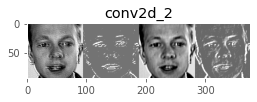

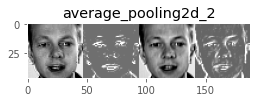

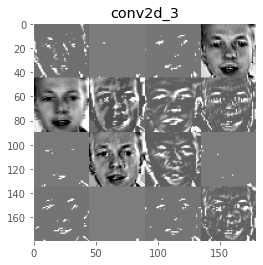

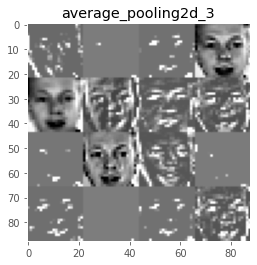

In [15]:
# Code Modified from: https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

# Model to feed in
model = LeNet5_knn

# Index of the sample image 
imgnum=3

# Print out all the layers, their names, and shapes 
print(model.summary())

# These are the layer outputs 
layer_outputs = [layer.output for layer in model.layers]

activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

# This is where you predict an input. I'm gonna try predicting just one image later, instead of the whole dev set, since VGG 16 is running out of memory 
activations = activation_model.predict(X_dev) 
# Each element in activations is a separate layer. Refer to summary for what these look like. 
# You could also do something like: activation[0].shape for the shape of the first layer 
# The shape will be in this form:   number of examples X size of feature map x size of feature map x number of channels

layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 4    

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    ## Only if shape has 4 numbers. So ignore flattened/fully connected layers
    if len(layer_activation.shape) == 4:
      
      n_features = layer_activation.shape[-1] # Number of features in the feature map
      size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).

      
      n_cols =  n_features // images_per_row # Tiles the activation channels in this matrix
      display_grid = np.zeros((size * n_cols, images_per_row * size))

      for col in range(n_cols): # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              channel_image = layer_activation[imgnum,   # image number
                                                :, :,
                                                col * images_per_row + row]
              # Post-processes the feature to make it visually palatable
              channel_image -= channel_image.mean() 
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, # Displays the grid
                            row * size : (row + 1) * size] = channel_image
      scale = 1. / size
      plt.figure(figsize=(scale * max(display_grid.shape[1], 1),
                          scale * max(display_grid.shape[0], 1)))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap="gray")


## VGG-16

VGG-16 is an architecture with a lot more layers. We wanted to see what the activations looked like. 

In [16]:
train_datagen_knn_augmented_triple_channel = FacialPointImageDataGenerator(
    X_data= X_train,
    y_data= Y_train_knn,
    shift_range=0.5,
    horizontal_flip_prob=0,
    rotation_deg_prob=0.5,
    batch_size=256,
    convertToRGB=True,
)

validation_datagen_knn_augmented_triple_channel = FacialPointImageDataGenerator(
    X_data= X_dev,
    y_data= Y_dev_knn,
    shift_range=0.0,
    horizontal_flip_prob=0.,
    rotation_deg_prob=0,
    batch_size=256,
    convertToRGB=True
)

def create_vgg16_model_with_transfer_learning(input_shape):
 
  #load VGG16 model pre-trained with imagenet
  pre_trained_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
  
  #freeze convolutional layers
  for layer in pre_trained_model.layers:
    layer.trainable = False

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(pre_trained_model.output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)                  
  x = layers.Dense  (30)(x) 
  model = Model(pre_trained_model.input, x)
  return model

VGG16_transfer_triple_channel = create_vgg16_model_with_transfer_learning((96,96,3))
#VGG16_transfer_triple_channel.summary()
VGG16_transfer_triple_channel.compile(optimizer='adam', loss='mean_squared_error')
VGG16_transfer_triple_channel.fit_generator(train_datagen_knn_augmented_triple_channel, validation_data=validation_datagen_knn_augmented_triple_channel, epochs=20)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
23/23 [==============================] - 12s 537ms/step - loss: 485.8860 - val_loss: 203.3501
Epoch 2/20
23/23 [==============================] - 12s 540ms/step - loss: 168.6773 - val_loss: 107.1395
Epoch 3/20
23/23 [==============================] - 12s 539ms/step - loss: 123.4215 - val_loss: 92.7510
Epoch 4/20
23/23 [==============================] - 13s 549ms/step - loss: 103.4963 - val_loss: 86.7966
Epoch 5/20
23/23 [==============================] - 13s 547ms/step - loss: 92.6283 - val_loss: 83.4352
Epoch 6/20
23/23 [==============================] - 13s 544ms/step - loss: 84.5766 - val_loss: 81.5682
Epoch 7/20
23/23 [==============================] - 12s 541ms/step - loss: 77.4686 - val_loss: 79.9899
Epoch 8/20
23/23 [==============================] - 12s 542ms/step - loss: 73.7147 - val_loss: 95.8955
Epoch 9/20
23/23 [==============================] - 12s 543ms/step - loss: 70.9470 - val_loss:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


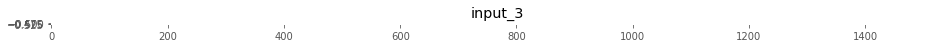

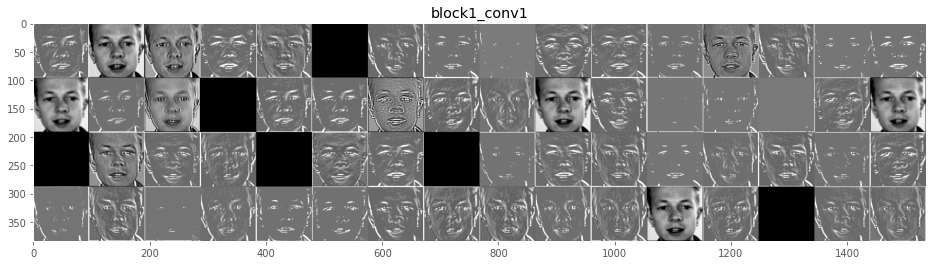

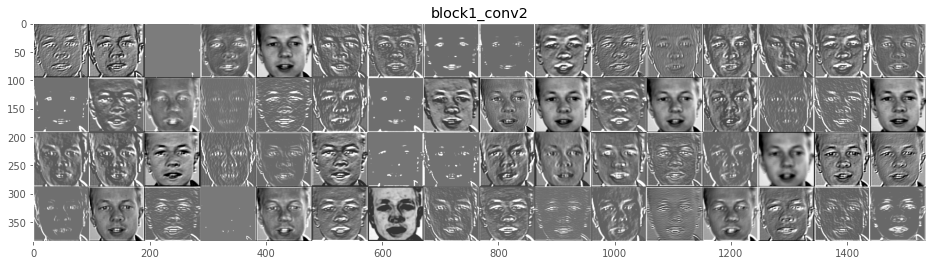

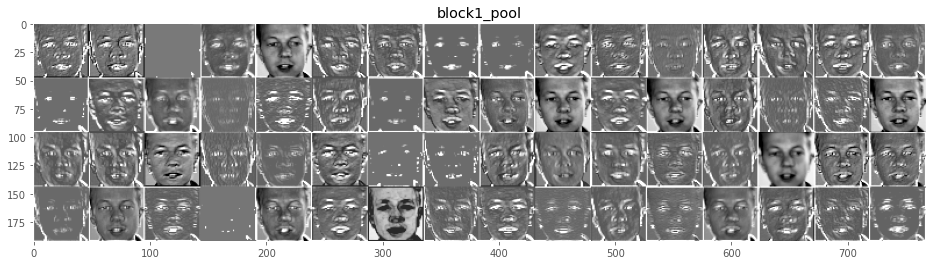

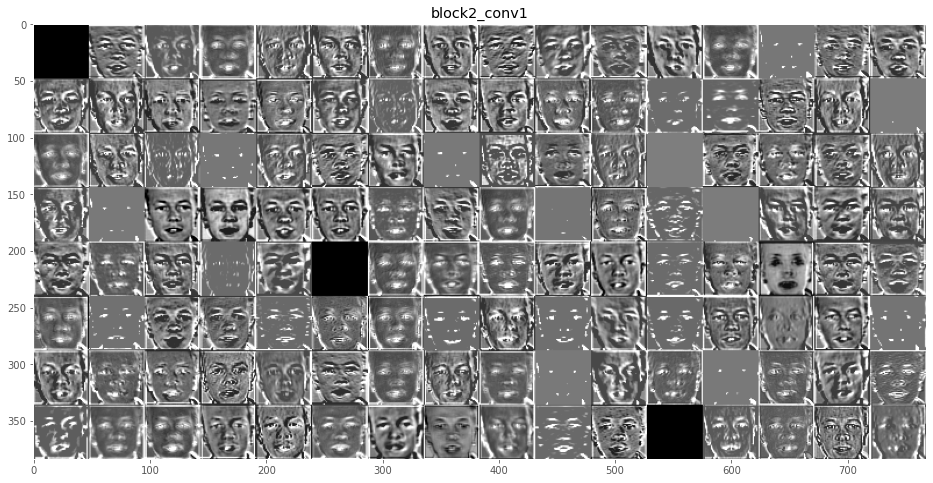

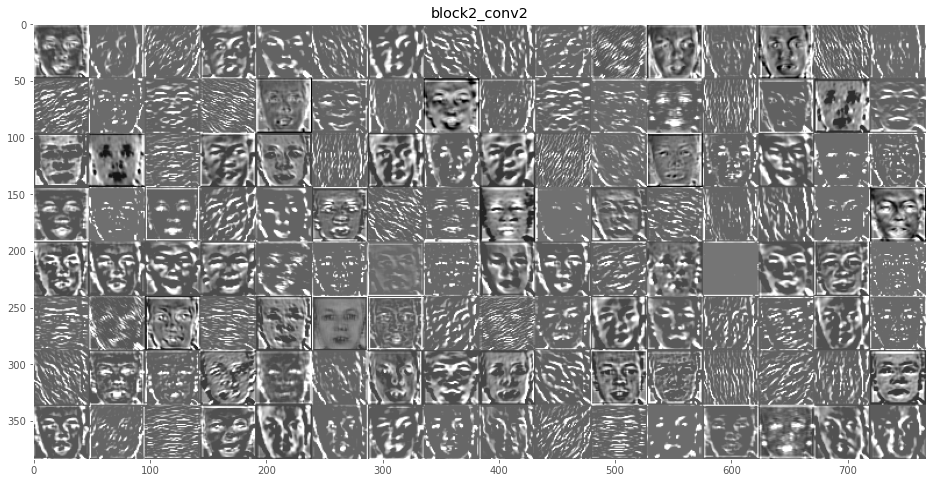

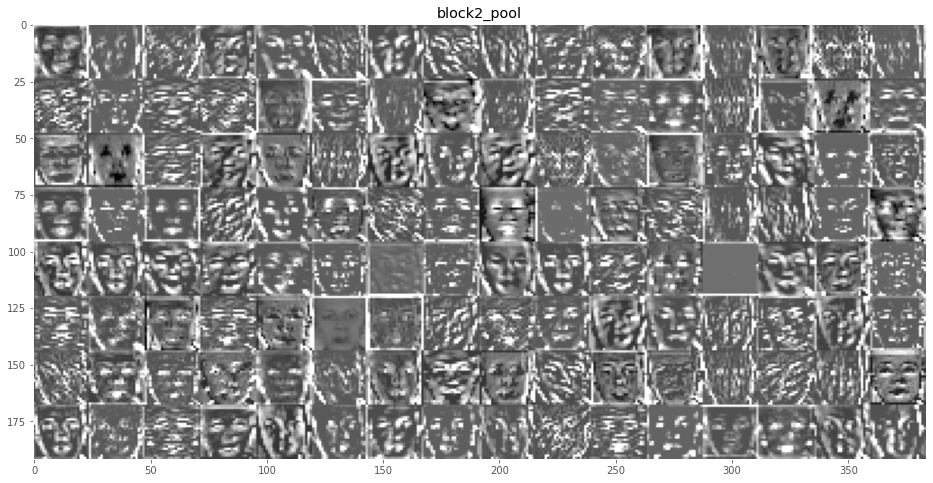

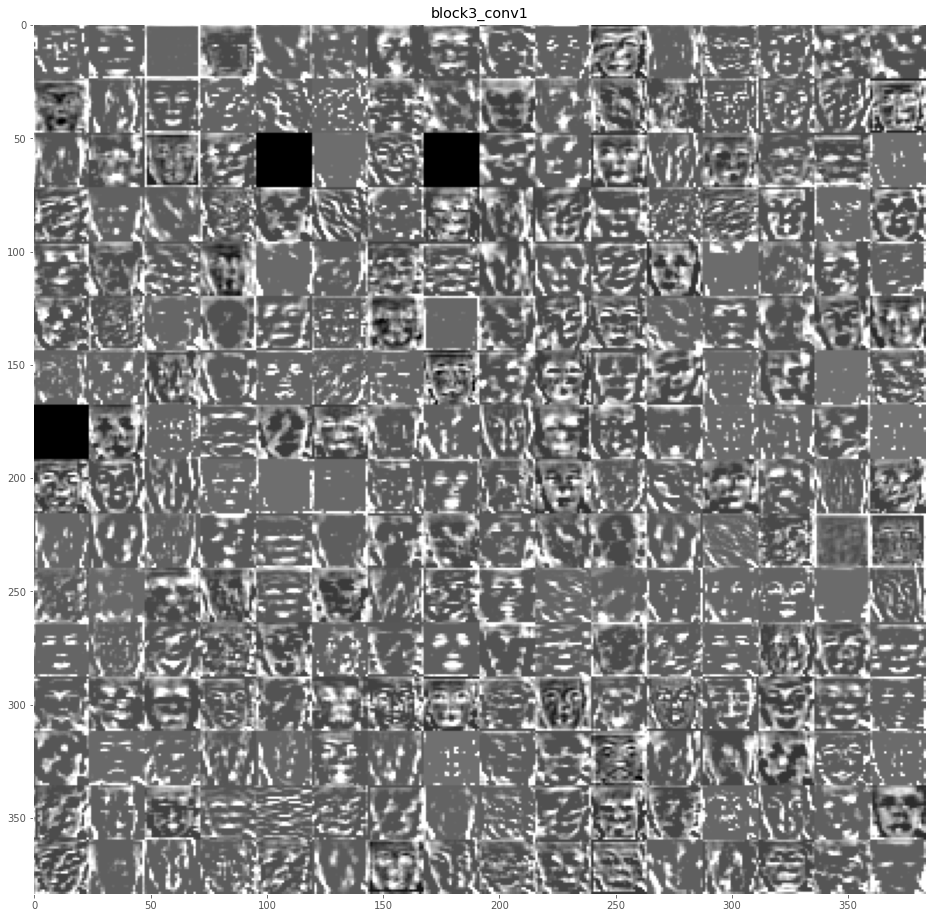

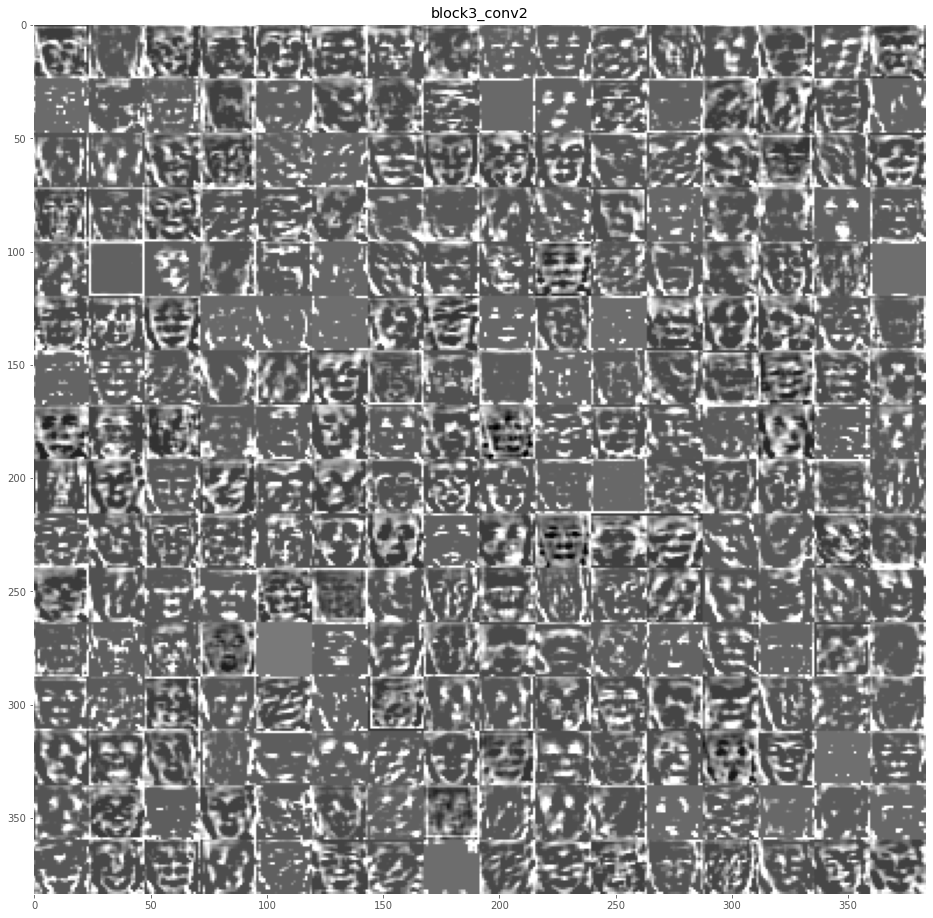

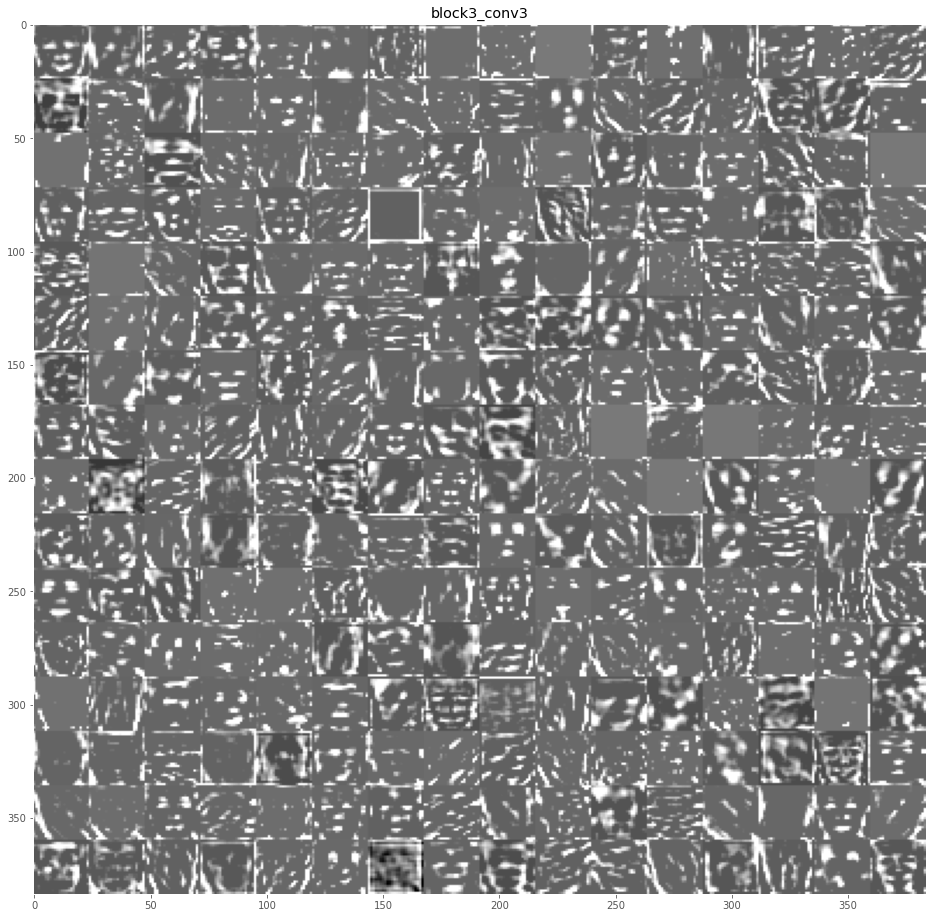

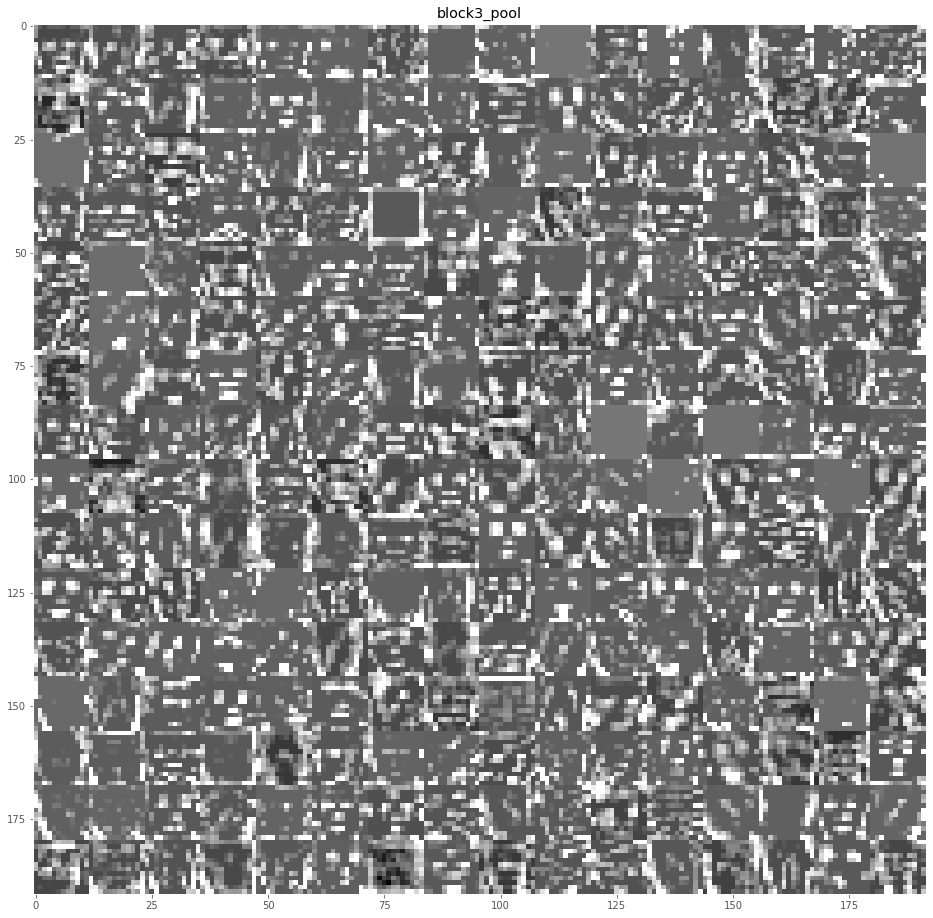

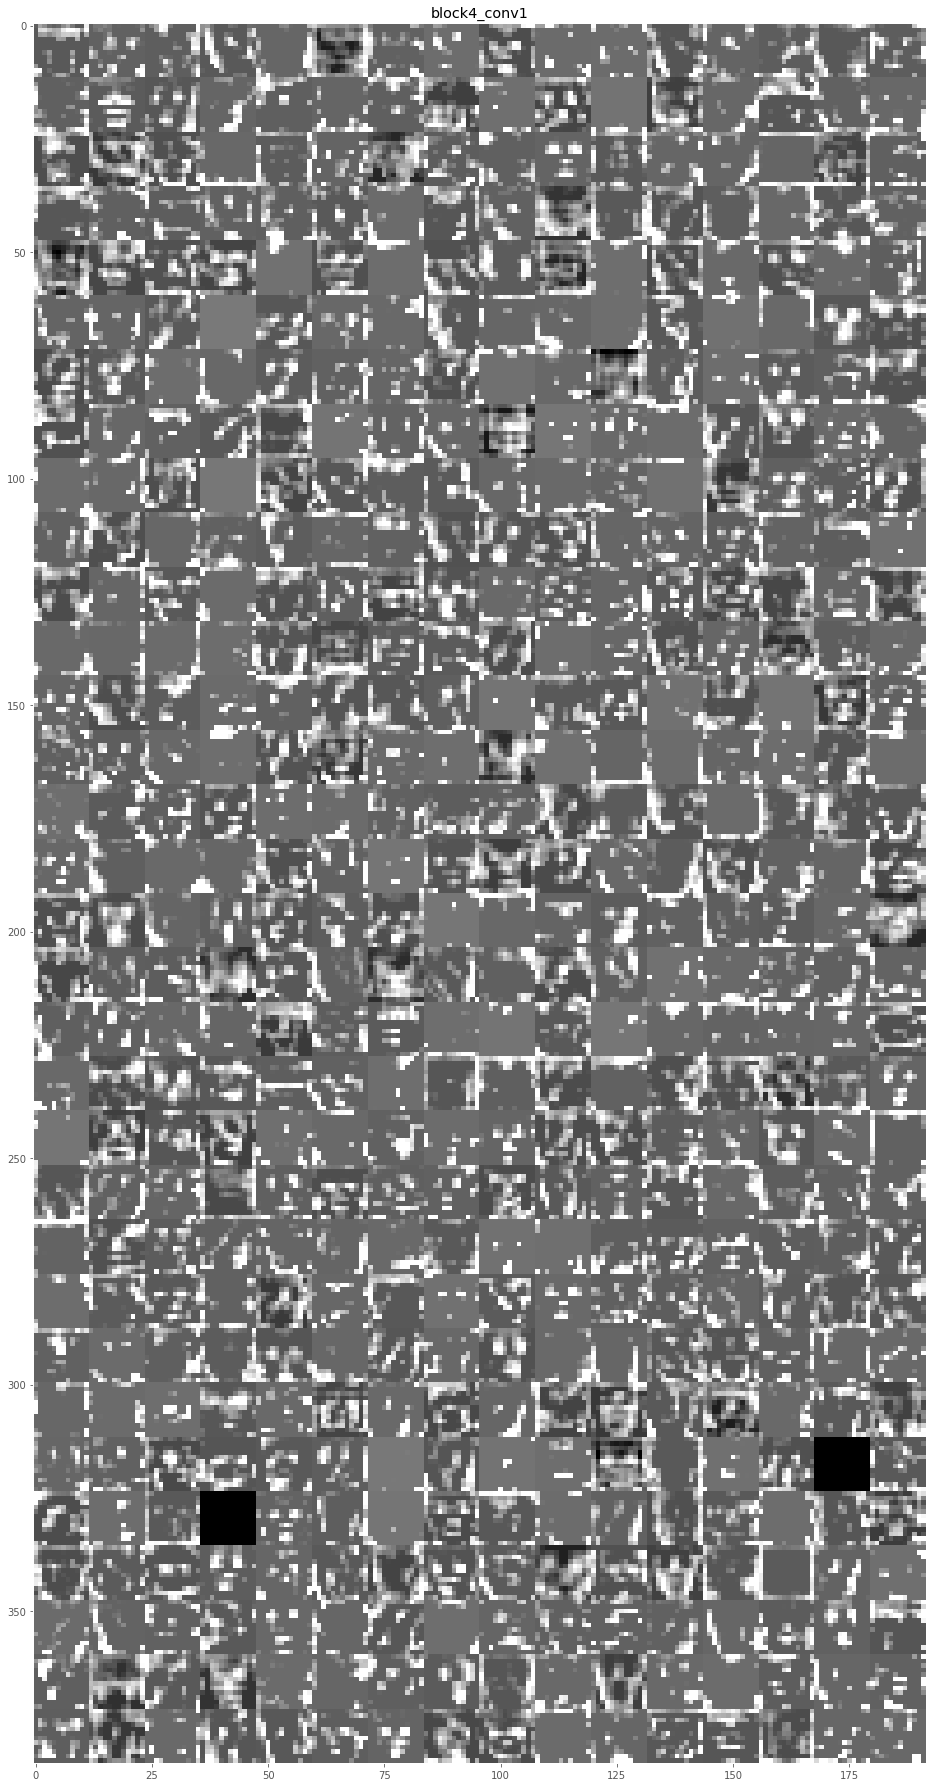

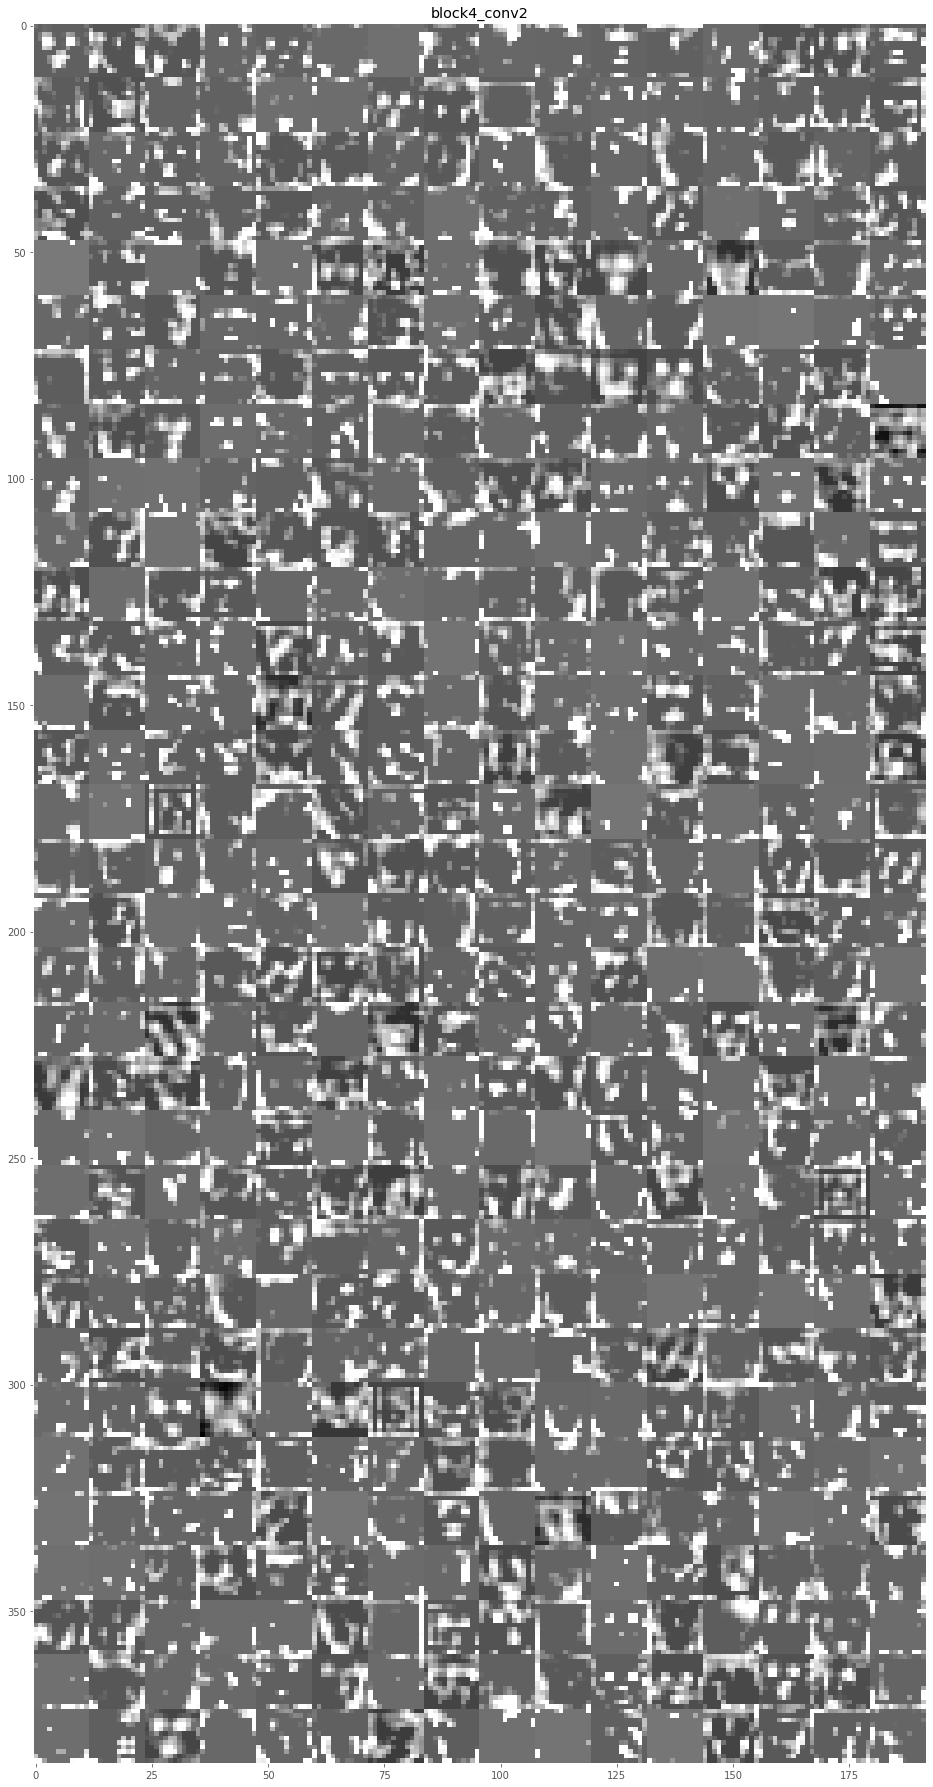

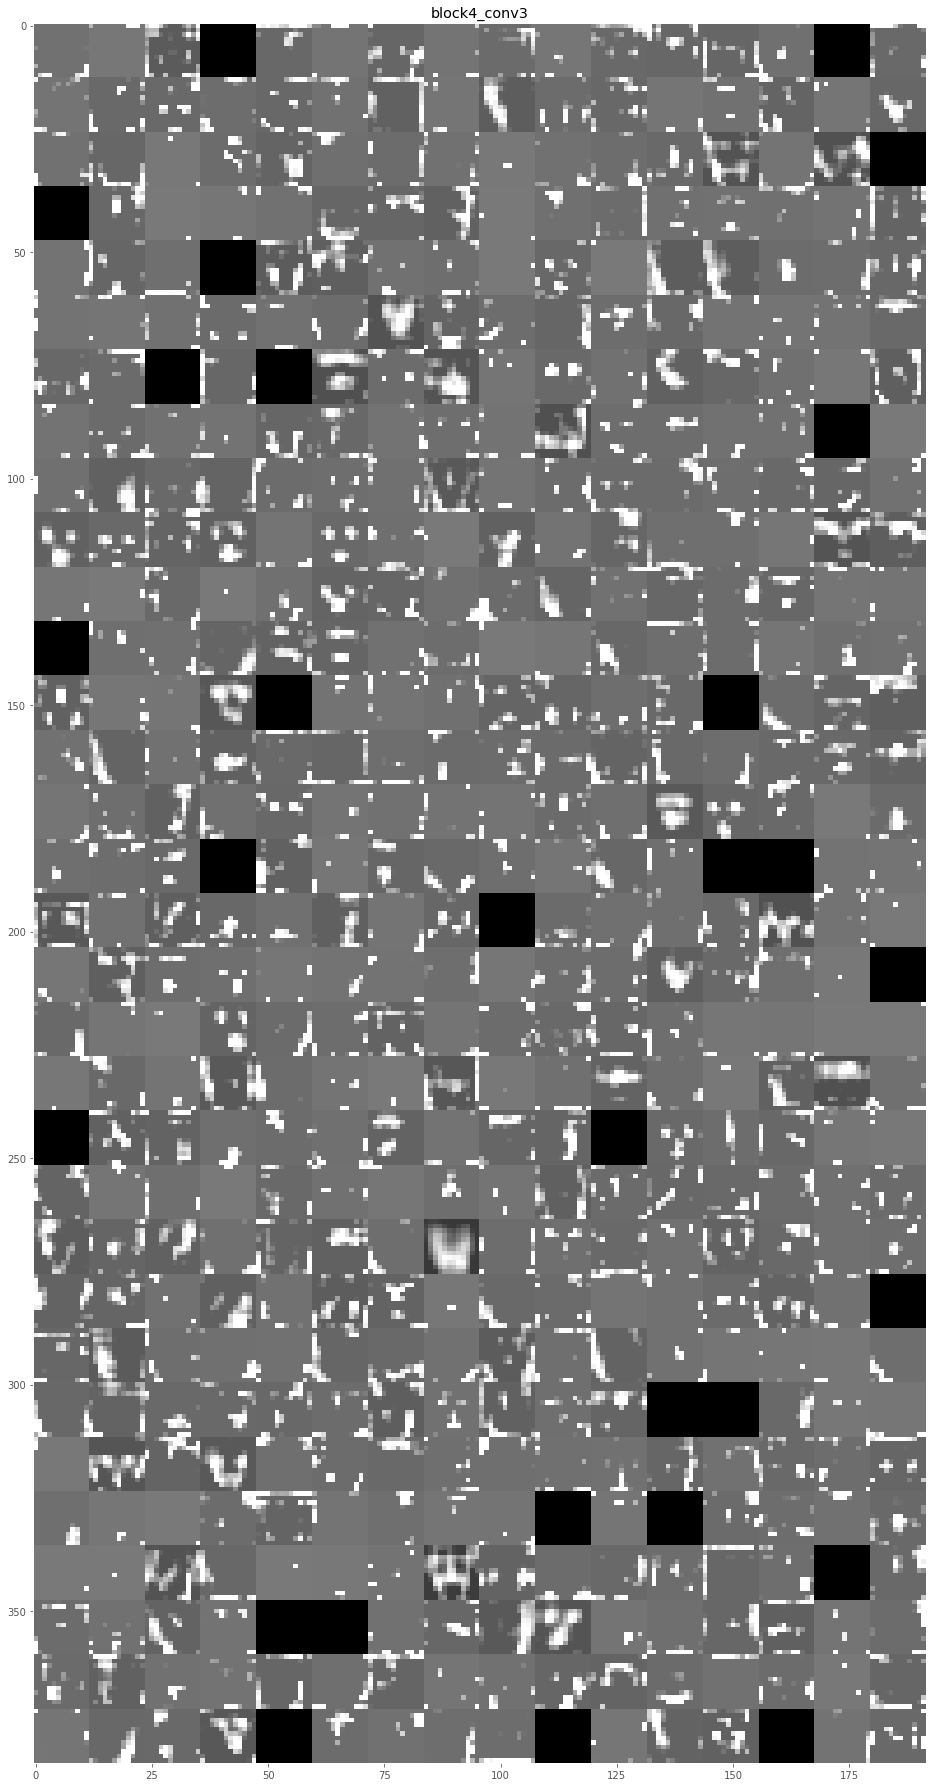

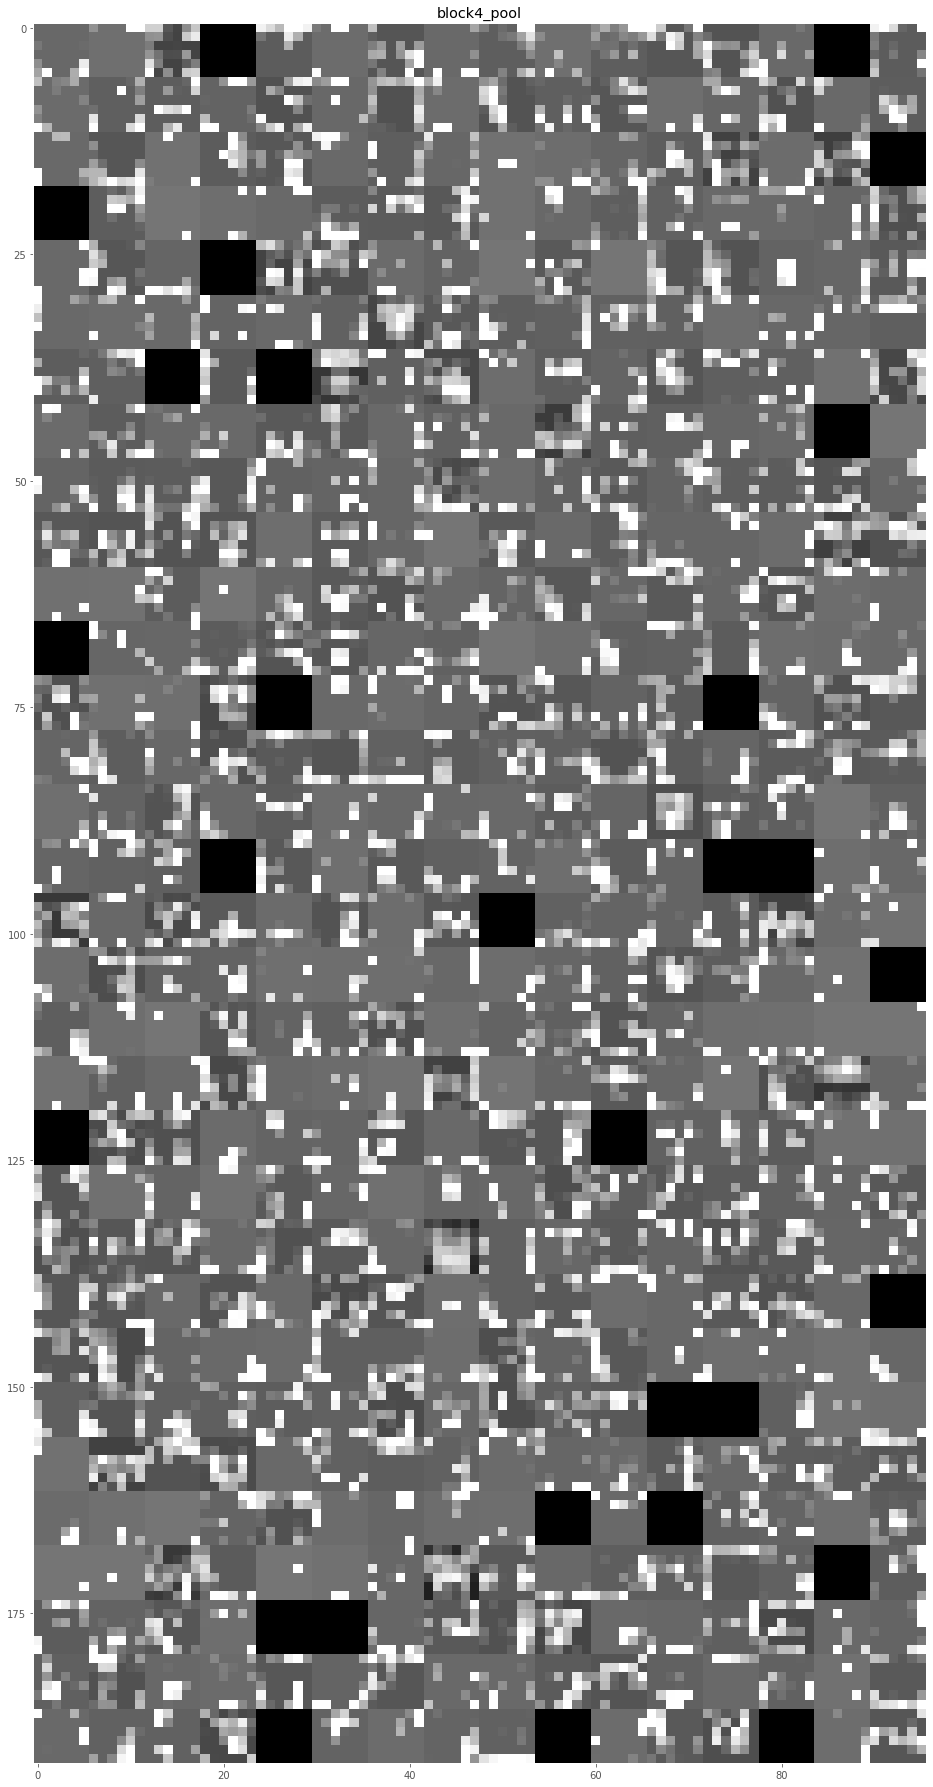

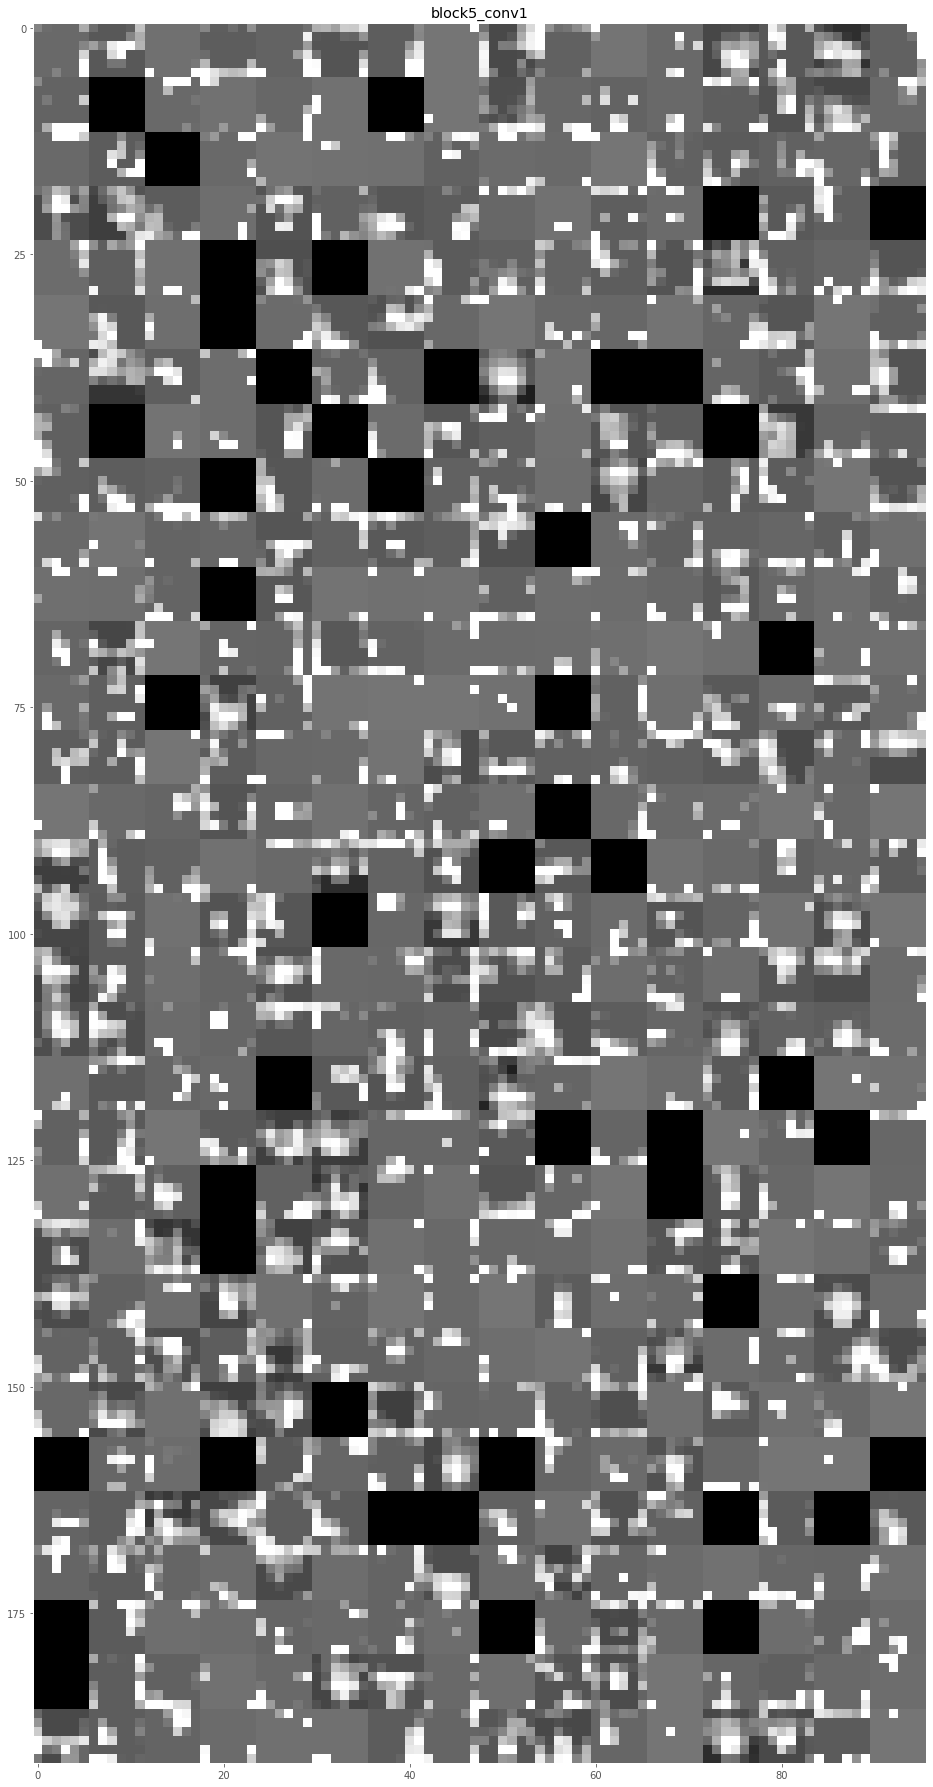

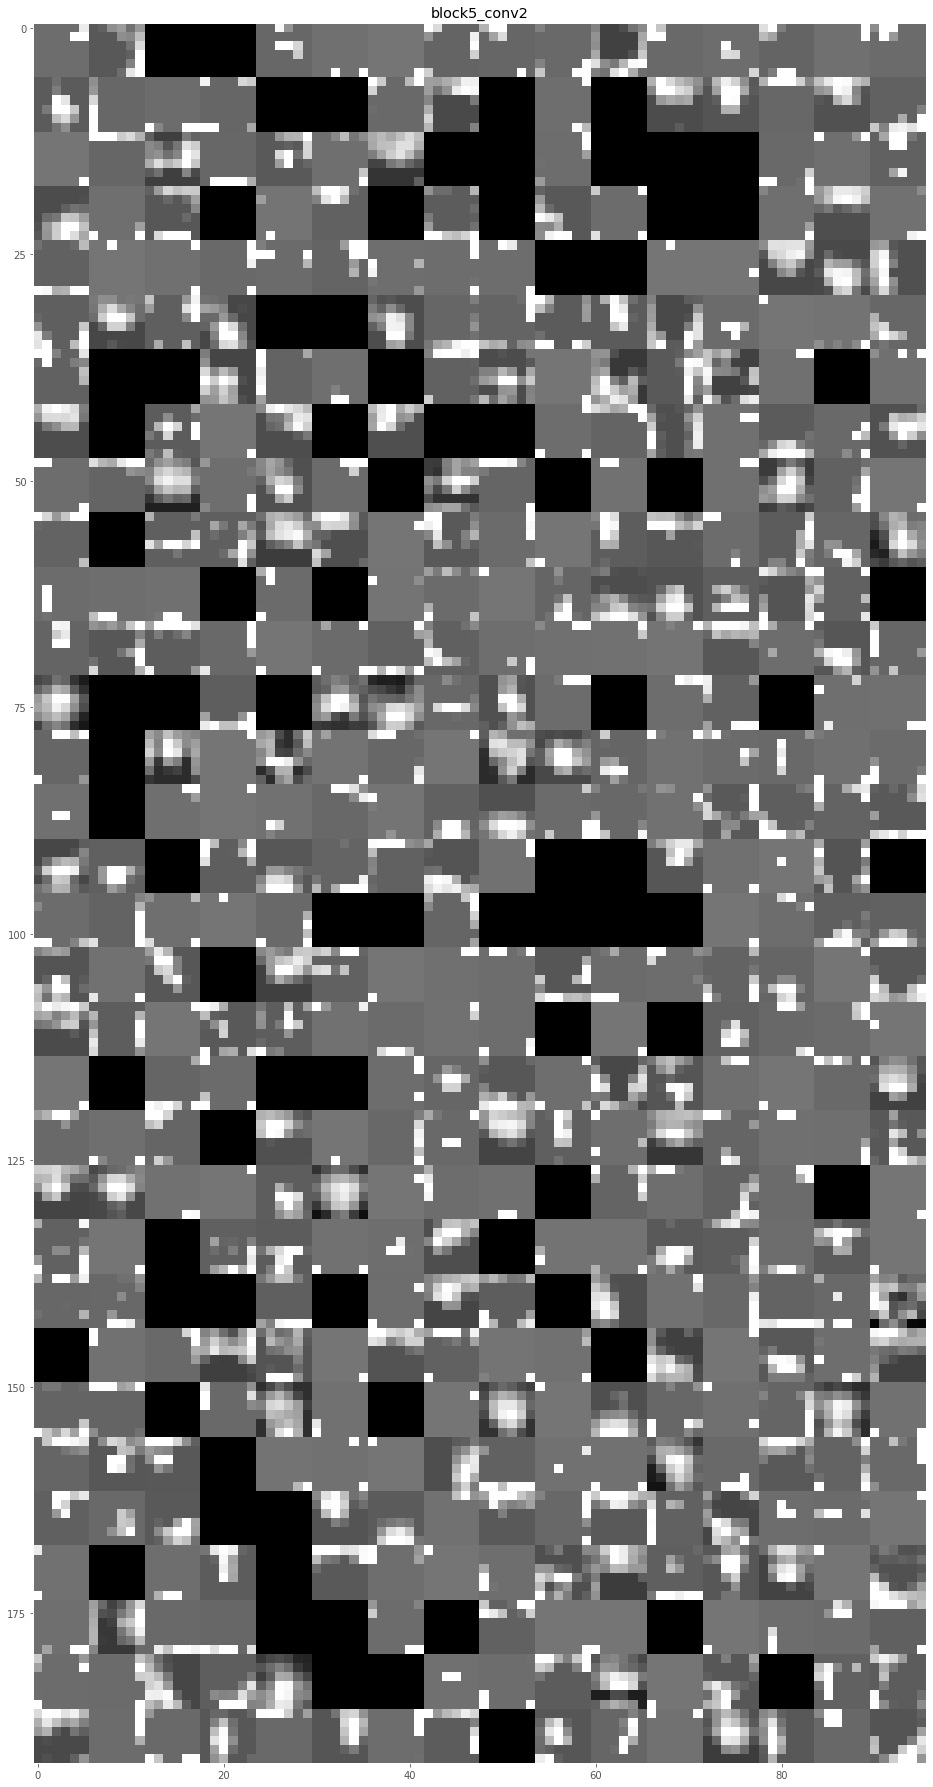

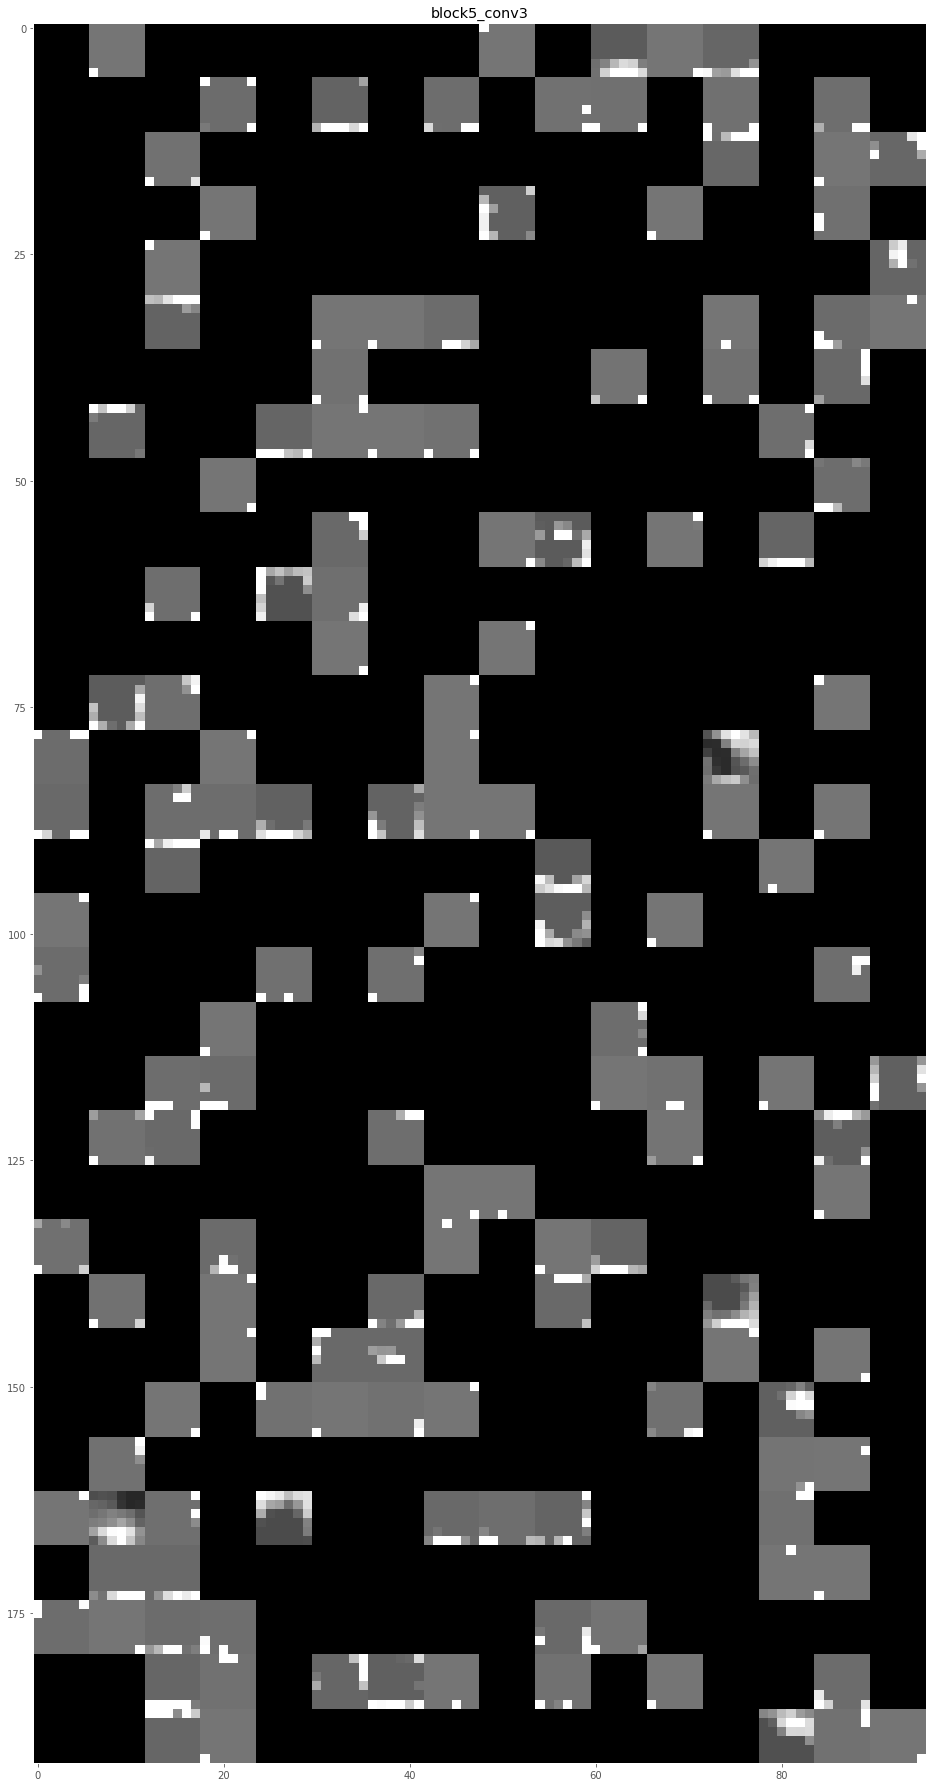

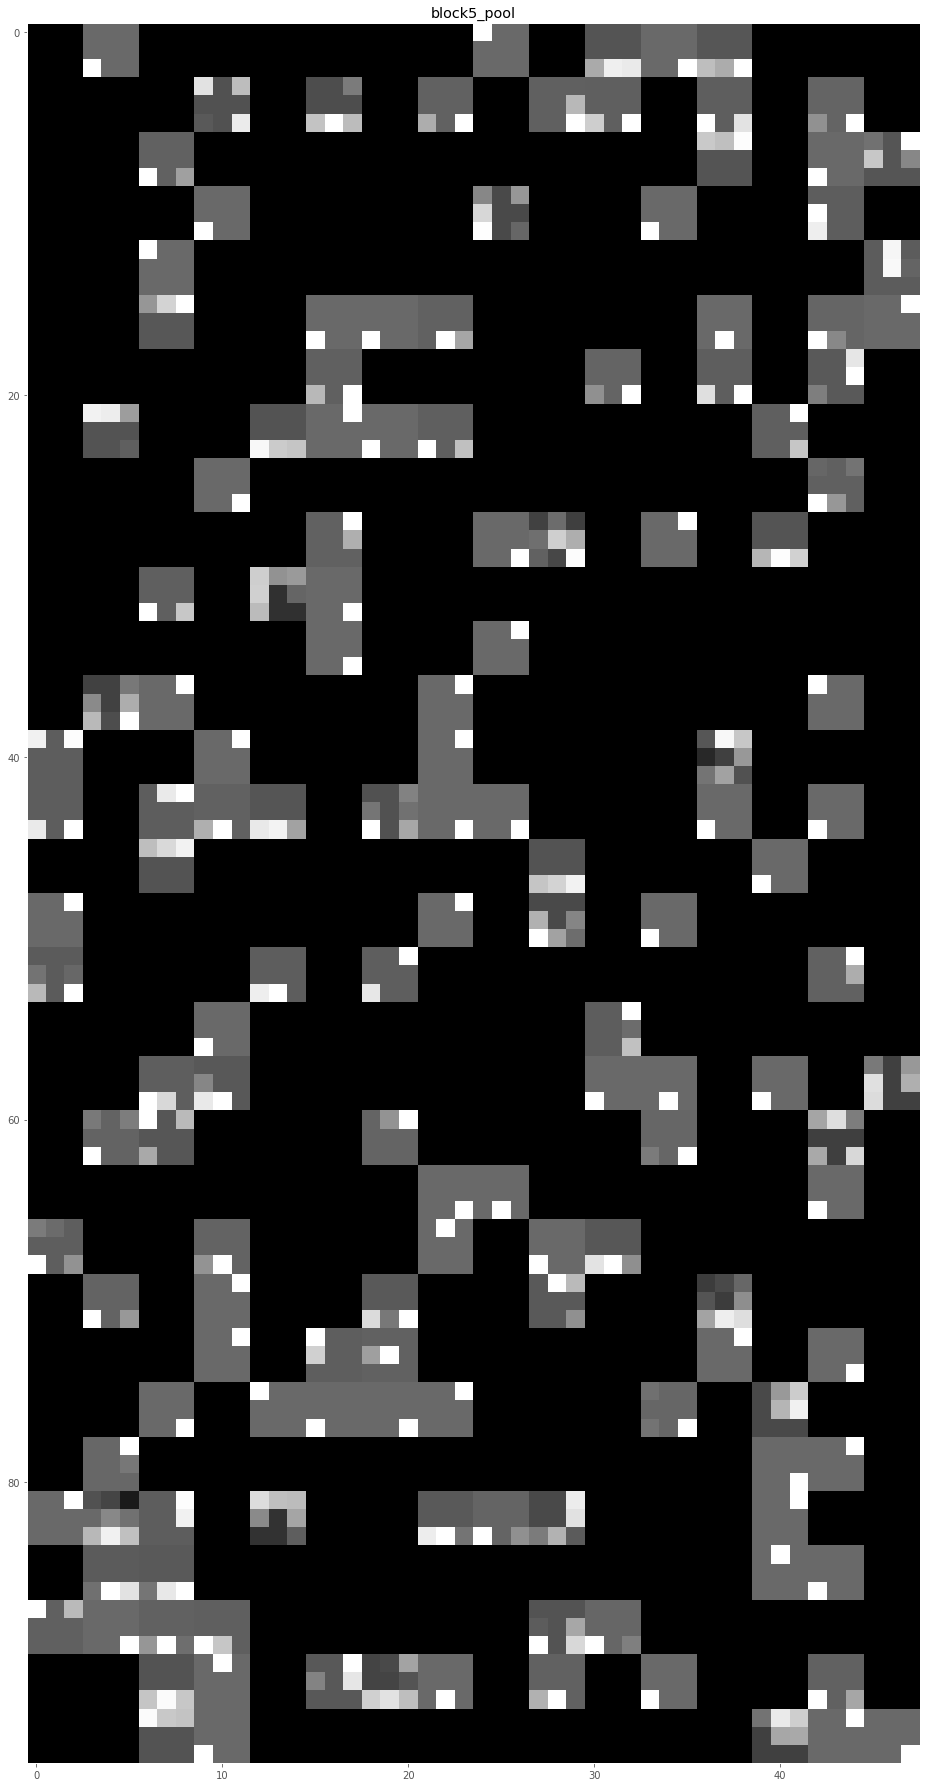

In [17]:
model = VGG16_transfer_triple_channel
model.summary()
sample_image = X_dev[3]
augmented_input = np.expand_dims(np.repeat(sample_image,3,axis=-1),axis=0)
predicted_input = augmented_input

def visualize_activations(model, sample_image, predicted_input):
  #which sample do you want to visualize?

  successive_outputs = [layer.output for layer in model.layers]
  visualization_model = tf.keras.models.Model(inputs = model.input , outputs = successive_outputs)
  activations  = visualization_model.predict(predicted_input)

  #Visualization code
  # layer_names = np.arange(0,1)    
  images_per_row = 16

  imgnum=0
  # These are the names of the layers, so can have them as part of our plot
  layer_names = [layer.name for layer in model.layers]
  for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
      ## Only if shape has 4 numbers. So ignore flattened/fully connected layers
      if len(layer_activation.shape) == 4:
      
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).      
        n_cols =  n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[imgnum,   # image number
                                                  :, :,
                                                  col * images_per_row + row]
                # Post-processes the feature to make it visually palatable
                channel_image -= channel_image.mean() 
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                              row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * max(display_grid.shape[1], 1),
                            scale * max(display_grid.shape[0], 1)))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap="gray")

visualize_activations(model, sample_image, predicted_input)